In [21]:
## Import packages

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# read file into pd dataframe

data = pd.read_csv(r'responsibility_data_sampled.csv', sep=";")
print(data.shape)
data.head()

(349, 44)


,OID,file_origin,Design,Level,Design_coded,Level_coded,TRUST,DOMINANCE,RHTRUST,Resp_Bic,Resp_Car,Resp_Driver,Resp_Producer,Sex,Age,Car_Owner,km_year,Education,Income,MC_autonom,MC_babyface,MC_baseline,MC_aggressive,MC_wide,Trust_1,Trust_2,Trust_3,RH_Trust_1,RH_Trust_2,RH_Trust_3,RH_Trust_4,RH_Trust_5,RH_Trust_6,RH_Trust_7,RH_Trust_8,RH_Trust_9,Dominance_1,Dominance_2,Dominance_3,Quality_1,Quality_2,Quality_3,Quality_4,Quality_5
0,1,Resp_Aggr_LP,1,1,aggressive,level 5,333.333.333.333.333,466.666.666.666.667,533.333.333.333.333,7,1,3,1,female,24,2,400,5,1,11,2,3,6,4,3,4,3,6,3,4,6,6,6,6,5,6,4,5,5,7,4,6,6,1
1,2,Resp_Aggr_LP,1,0,aggressive,level 3,5,4,522.222.222.222.222,2,4,7,5,female,29,2,2000,5,1,6,1,4,1,3,5,5,5,5,5,5,5,6,4,6,6,5,4,1,7,6,2,7,7,1
2,4,Resp_Aggr_LP,1,1,aggressive,level 5,666.666.666.666.667,433.333.333.333.333,666.666.666.666.667,5,3,6,4,male,19,2,5000,5,1,8,3,2,3,3,7,7,6,7,7,7,7,7,5,7,6,7,5,3,5,7,6,7,6,1
3,5,Resp_Aggr_LP,0,0,baseline,level 3,466.666.666.666.667,333.333.333.333.333,411.111.111.111.111,6,4,6,6,male,50,1,40000,5,0,10,3,6,2,3,4,5,5,5,4,4,4,4,4,4,4,4,2,2,6,6,2,6,6,1
4,6,Resp_Aggr_LP,0,0,baseline,level 3,233.333.333.333.333,466.666.666.666.667,488.888.888.888.889,1,1,7,4,male,21,2,300,5,1,6,5,6,5,5,1,5,1,5,5,6,7,4,1,5,5,6,3,4,7,5,4,7,6,1


In [3]:
print(data['Design'].value_counts().sort_index())
print(data['Level'].value_counts().sort_index())

0    96
1    90
2    79
3    84
Name: Design, dtype: int64
0    180
1    169
Name: Level, dtype: int64


In [4]:
# Delete "Wide"-condition

#annotation Design:
#0 = baseline
#1 = aggressive
#2 = babyfaced
#3 = wide

data = data[data['Design'] < 3]
data.shape

(265, 44)

In [12]:
data.columns

Index(['OID', 'file_origin', 'Design', 'Level', 'Design_coded', 'Level_coded',
       'TRUST', 'DOMINANCE', 'RHTRUST', 'Resp_Bic', 'Resp_Car', 'Resp_Driver',
       'Resp_Producer', 'Sex', 'Age', 'Car_Owner', 'km_year', 'Education',
       'Income', 'MC_autonom', 'MC_babyface', 'MC_baseline', 'MC_aggressive',
       'MC_wide', 'Trust_1', 'Trust_2', 'Trust_3', 'RH_Trust_1', 'RH_Trust_2',
       'RH_Trust_3', 'RH_Trust_4', 'RH_Trust_5', 'RH_Trust_6', 'RH_Trust_7',
       'RH_Trust_8', 'RH_Trust_9', 'Dominance_1', 'Dominance_2', 'Dominance_3',
       'Quality_1', 'Quality_2', 'Quality_3', 'Quality_4', 'Quality_5'],
      dtype='object')

In [15]:
# function for displaying eta_squared as measure of effect size in ANOVA

def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

In [20]:
# Two-factorial ANOVA with Design and Level as Factors and Resp_Bic, Resp_Car, Resp_Driver, Resp_Producer as Outcomes



for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:

    formula = '{} ~ C(Level) + C(Design) + C(Level):C(Design)'.format(resp)
    model = ols(formula, data).fit()
    aov_table = anova_lm(model, typ=2)
    eta_squared(aov_table)
    print('ANOVA on {}'.format(resp)+'\n',aov_table.round(4))
    print('\n')

ANOVA on Resp_Bic
                       sum_sq     df       F  PR(>F)  eta_sq
C(Level)              0.3522    1.0  0.1351  0.7135  0.0005
C(Design)            36.9327    2.0  7.0803  0.0010  0.0516
C(Level):C(Design)    2.9699    2.0  0.5694  0.5666  0.0041
Residual            675.5045  259.0     NaN     NaN     NaN


ANOVA on Resp_Car
                       sum_sq     df        F  PR(>F)  eta_sq
C(Level)             73.3199    1.0  25.9064  0.0000  0.0837
C(Design)            30.1282    2.0   5.3227  0.0054  0.0344
C(Level):C(Design)   39.4793    2.0   6.9747  0.0011  0.0451
Residual            733.0181  259.0      NaN     NaN     NaN


ANOVA on Resp_Driver
                       sum_sq     df        F  PR(>F)  eta_sq
C(Level)            228.1990    1.0  77.0822  0.0000  0.2054
C(Design)            70.1700    2.0  11.8512  0.0000  0.0632
C(Level):C(Design)   46.0212    2.0   7.7726  0.0005  0.0414
Residual            766.7604  259.0      NaN     NaN     NaN


ANOVA on Resp_Producer
 

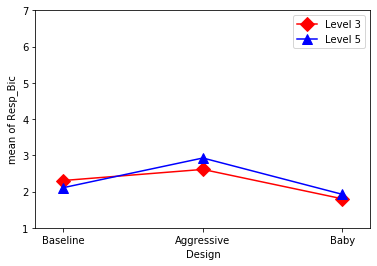

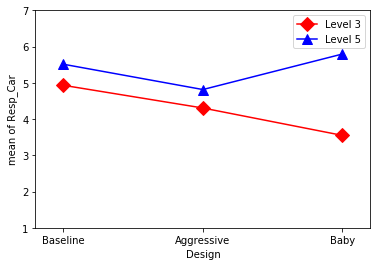

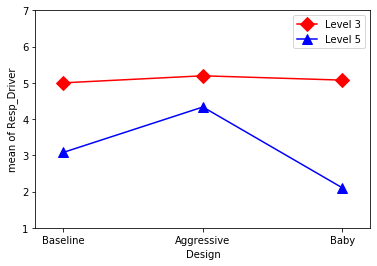

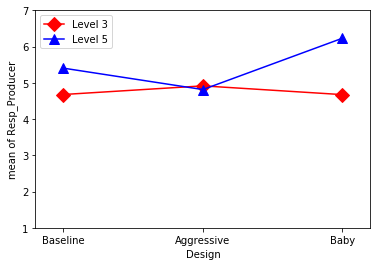

In [14]:
# Visualizing factorial data with statsmodel interaction_plot

for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:

    fig = interaction_plot(data['Design'], data['Level'], data[resp],
                       colors=['red','blue'], markers=['D','^'], ms=10)

    plt.xticks([0,1,2], labels=['Baseline', 'Aggressive', 'Baby'])
    plt.ylim(1,7)
    plt.legend(['Level 3', 'Level 5'])
    plt.show()


In [22]:
#Post-hoc testing of mean differences for different levels of automation

# display mean values and std. deviations by level and design

means_by_cond = pd.pivot_table(data, 
                               values=['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer'], 
                               index=['Level', 'Design'], aggfunc=[np.mean, np.std])
means_by_cond

mean                                           std  \
              Resp_Bic  Resp_Car Resp_Driver Resp_Producer  Resp_Bic   
Level Design                                                           
0     0       2.305085  4.932203    5.000000      4.677966  1.694354   
      1       2.611111  4.305556    5.194444      4.916667  1.678056   
      2       1.800000  3.550000    5.075000      4.675000  1.604481   
1     0       2.108108  5.513514    3.081081      5.405405  1.307750   
      1       2.925926  4.814815    4.333333      4.814815  1.702959   
      2       1.923077  5.794872    2.102564      6.230769  1.579217   

                                                  
              Resp_Car Resp_Driver Resp_Producer  
Level Design                                      
0     0       1.720710    1.473911      1.467354  
      1       2.011672    1.753681      1.841971  
      2       1.153590    1.491643      1.542351  
1     0       1.574477    1.934746      1.739404  
      1       1.972204    2.009412      1.853849  
      2       1.379922    1.602545      1.346761

In [24]:
#Levene's test vor variance equality

W, p = stats.levene(data[(data['Level']==0) & (data['Design']==0)]['Resp_Bic'], data[(data['Level']==0) & (data['Design']==1)]['Resp_Bic'])

print('Levene test statistic: {}, p = {}'.format(W, p))


Levene test statistic: 0.17358043213787364, p = 0.6779092066506753


In [25]:
#t-test

t, p = stats.ttest_ind(data[(data['Level']==0) & (data['Design']==0)]['Resp_Bic'], data[(data['Level']==0) & (data['Design']==1)]['Resp_Bic'])
print('t-value = {}, p = {}'.format(t, p))

tvalue = -0.8571175223825969, p = 0.3935832632918522


In [36]:
for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
    for level in sorted(data['Level'].unique()):
        print('\nT-tests for {} on automation level {}'.format(resp, level))
        values = data[data['Level']==level][['Design', resp]]
        for design in sorted(data['Design'].unique()):
            if design == 2:
                one = 0
                two = 2
            else:
                one = design
                two = design+1
            
            if stats.levene(values[values['Design']==one][resp], values[values['Design']==two][resp])[1] < .05:
                t, p = stats.ttest_ind(values[values['Design']==one][resp], values[values['Design']==two][resp], equal_var=False)
            else:
                t, p = stats.ttest_ind(values[values['Design']==one][resp], values[values['Design']==two][resp])
            print('Comparing means of {} and {}: t-value = {}, p = {}'.format(one, two, round(t,4), round(p,4)))


T-tests for Resp_Bic on automation level 0
Comparing means of 0 and 1: t-value = -0.8571, p = 0.3936
Comparing means of 1 and 2: t-value = 2.1532, p = 0.0346
Comparing means of 0 and 2: t-value = 1.4866, p = 0.1404

T-tests for Resp_Bic on automation level 1
Comparing means of 0 and 1: t-value = -2.5871, p = 0.0113
Comparing means of 1 and 2: t-value = 2.888, p = 0.0048
Comparing means of 0 and 2: t-value = 0.5547, p = 0.5808

T-tests for Resp_Car on automation level 0
Comparing means of 0 and 1: t-value = 1.6142, p = 0.1099
Comparing means of 1 and 2: t-value = 1.9795, p = 0.0528
Comparing means of 0 and 2: t-value = 4.4446, p = 0.0

T-tests for Resp_Car on automation level 1
Comparing means of 0 and 1: t-value = 1.7971, p = 0.0757
Comparing means of 1 and 2: t-value = -2.8192, p = 0.0059
Comparing means of 0 and 2: t-value = -0.8296, p = 0.4094

T-tests for Resp_Driver on automation level 0
Comparing means of 0 and 1: t-value = -0.5561, p = 0.58
Comparing means of 1 and 2: t-value =